In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#          print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [9]:
from io import StringIO

raw_label_data = """ClassId,SignName
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)
9,No passing
10,No passing for vehicles over 3.5 metric tons
11,Right-of-way at the next intersection
12,Priority road
13,Yield
14,Stop
15,No vehicles
16,Vehicles over 3.5 metric tons prohibited
17,No entry
18,General caution
19,Dangerous curve to the left
20,Dangerous curve to the right
21,Double curve
22,Bumpy road
23,Slippery road
24,Road narrows on the right
25,Road work
26,Traffic signals
27,Pedestrians
28,Children crossing
29,Bicycles crossing
30,Beware of ice/snow
31,Wild animals crossing
32,End of all speed and passing limits
33,Turn right ahead
34,Turn left ahead
35,Ahead only
36,Go straight or right
37,Go straight or left
38,Keep right
39,Keep left
40,Roundabout mandatory
41,End of no passing
42,End of no passing by vehicles over 3.5 metric tons
"""

labels_df = pd.read_csv(StringIO(raw_label_data))

In [10]:
labels = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Meta.csv')
class_labels = dict(zip(labels_df.ClassId, labels_df.SignName))

# Collect counts in a list
data = []

train_path = '/kaggle/input/gtsrb-german-traffic-sign/Train'
for dirs in os.listdir(train_path):
    class_id = int(dirs)
    count = len(os.listdir(os.path.join(train_path, dirs)))
    label = class_labels[class_id]
    data.append((class_id, label, count))

#Creat a DataFrame
df = pd.DataFrame(data, columns = ["ClassId", "Label", "Count"])
df

,ClassId,Label,Count
0,7,Speed limit (100km/h),1440
1,17,No entry,1110
2,19,Dangerous curve to the left,210
3,22,Bumpy road,390
4,2,Speed limit (50km/h),2250
5,35,Ahead only,1200
6,23,Slippery road,510
7,10,No passing for vehicles over 3.5 metric tons,2010
8,5,Speed limit (80km/h),1860
9,36,Go straight or right,390


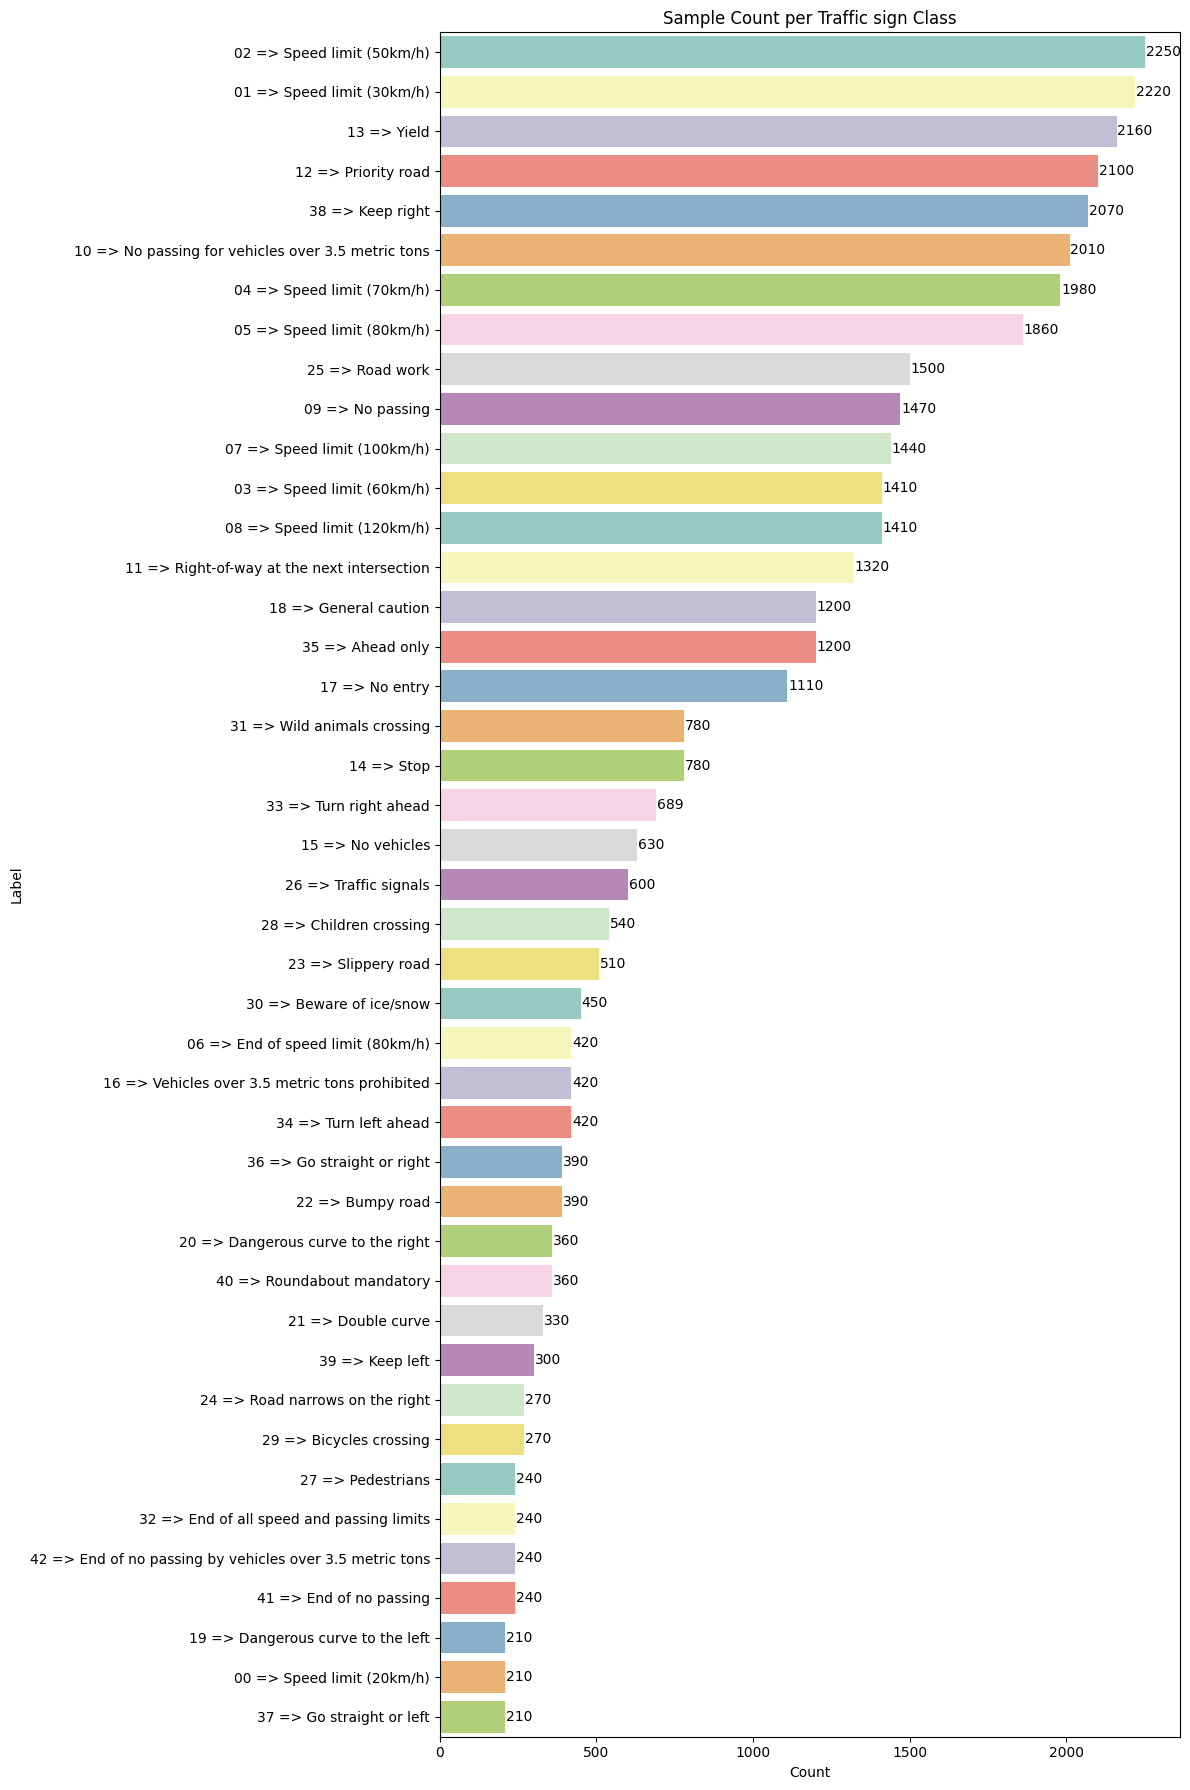

In [11]:
df_sorted = df.sort_values(by = "Count", ascending = False)

# Add labeled column (e.g. "00 => Speed limit (20km/h)")
df_sorted ["ClassLabel"] = df_sorted["ClassId"].apply(lambda x: f"{x:02d}") + " => " + df_sorted["Label"]

plt.figure(figsize = (12, 18))
ax = sns.barplot(data = df_sorted, y = "ClassLabel", x = "Count", palette = 'Set3')
plt.title("Sample Count per Traffic sign Class")
plt.ylabel('Label')
plt.xlabel('Count')
plt.tight_layout()

# Add count labels to eaxh bar
for i in ax.patches:
    count = int(i.get_width())
    y = i.get_y() + i.get_height() / 2
    ax.text(count + 3, y, str(count), va = 'center')

plt.show();

In [12]:
print("Num labels: ", len(labels))

Num labels:  43


In [15]:
df1 = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Meta.csv', delimiter=',')
df1.dataframeName = 'Meta.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 43 rows and 5 columns


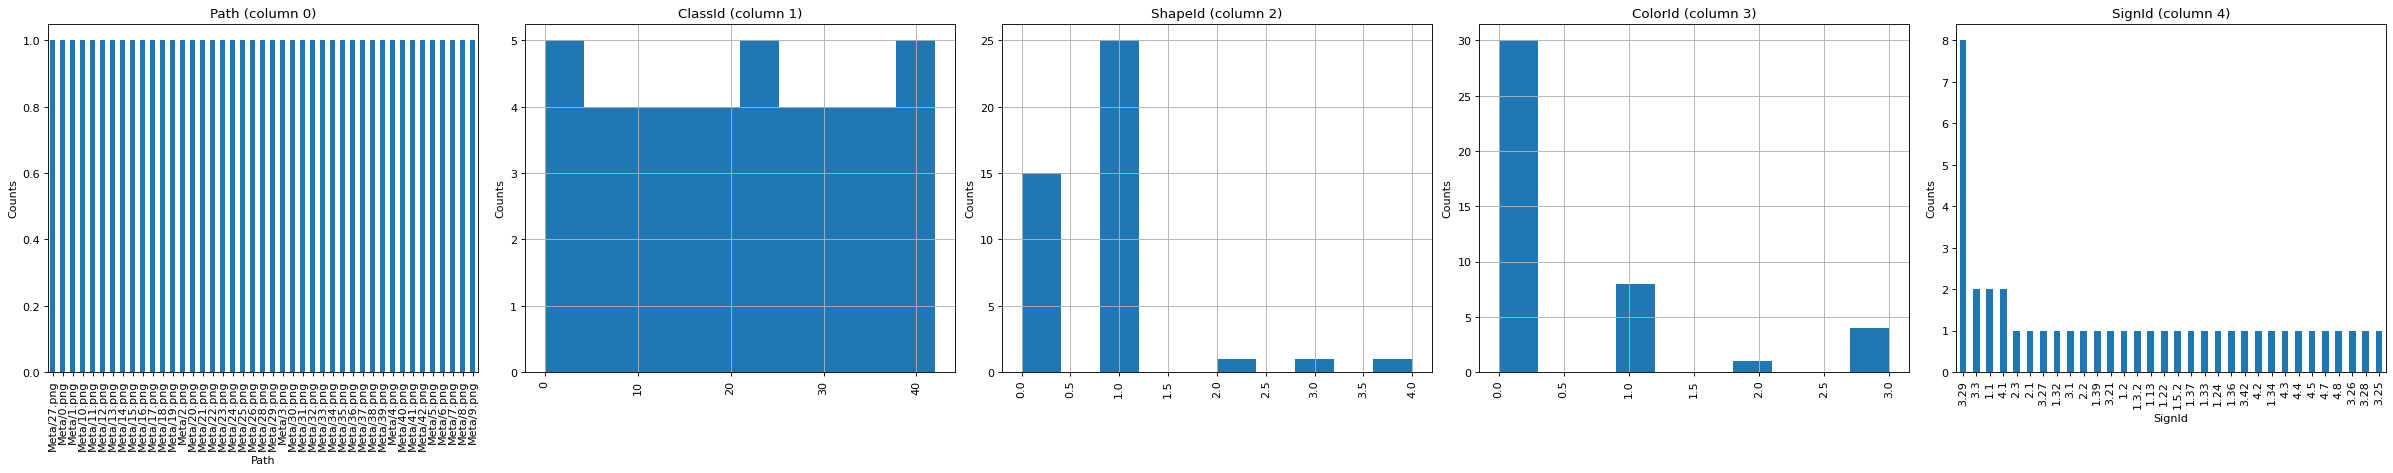

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plotPerColumnDistribution(df, nGraphShown=10, nGraphPerRow=5):
    nunique = df.nunique()
    df = df[[col for col in df if 1 < nunique[col] < 50]]  # Keep only columns with 2–49 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow  # Integer division

    plt.figure(figsize=(6 * nGraphPerRow, 6 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(columnDf.dtype, np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')

    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()
plotPerColumnDistribution(df1, 10, 5)


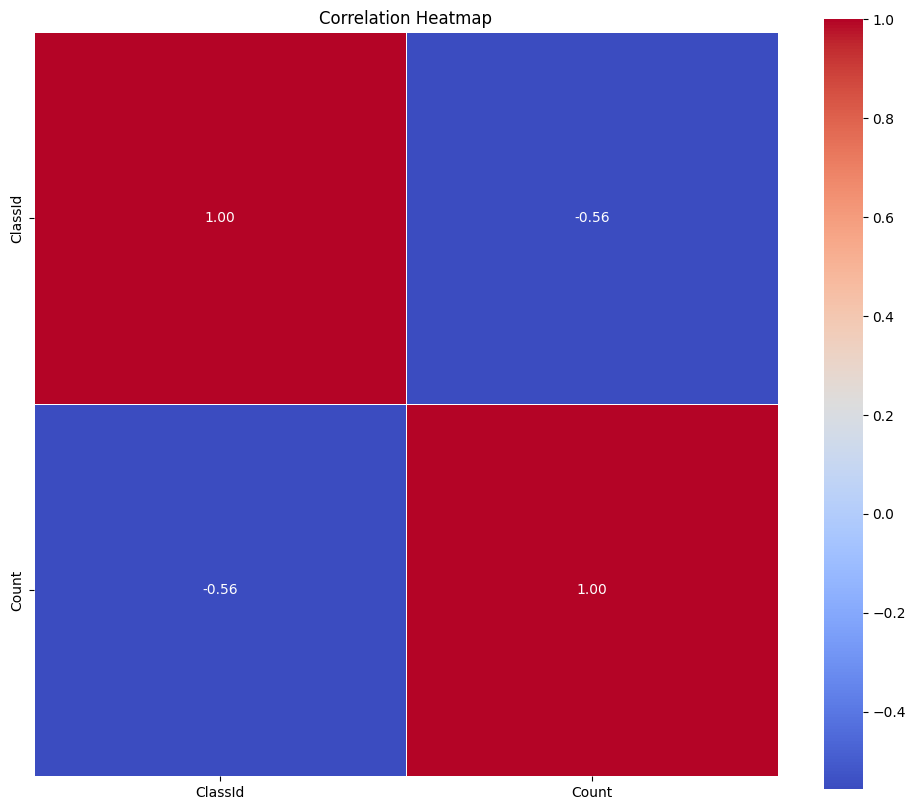

In [19]:

plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


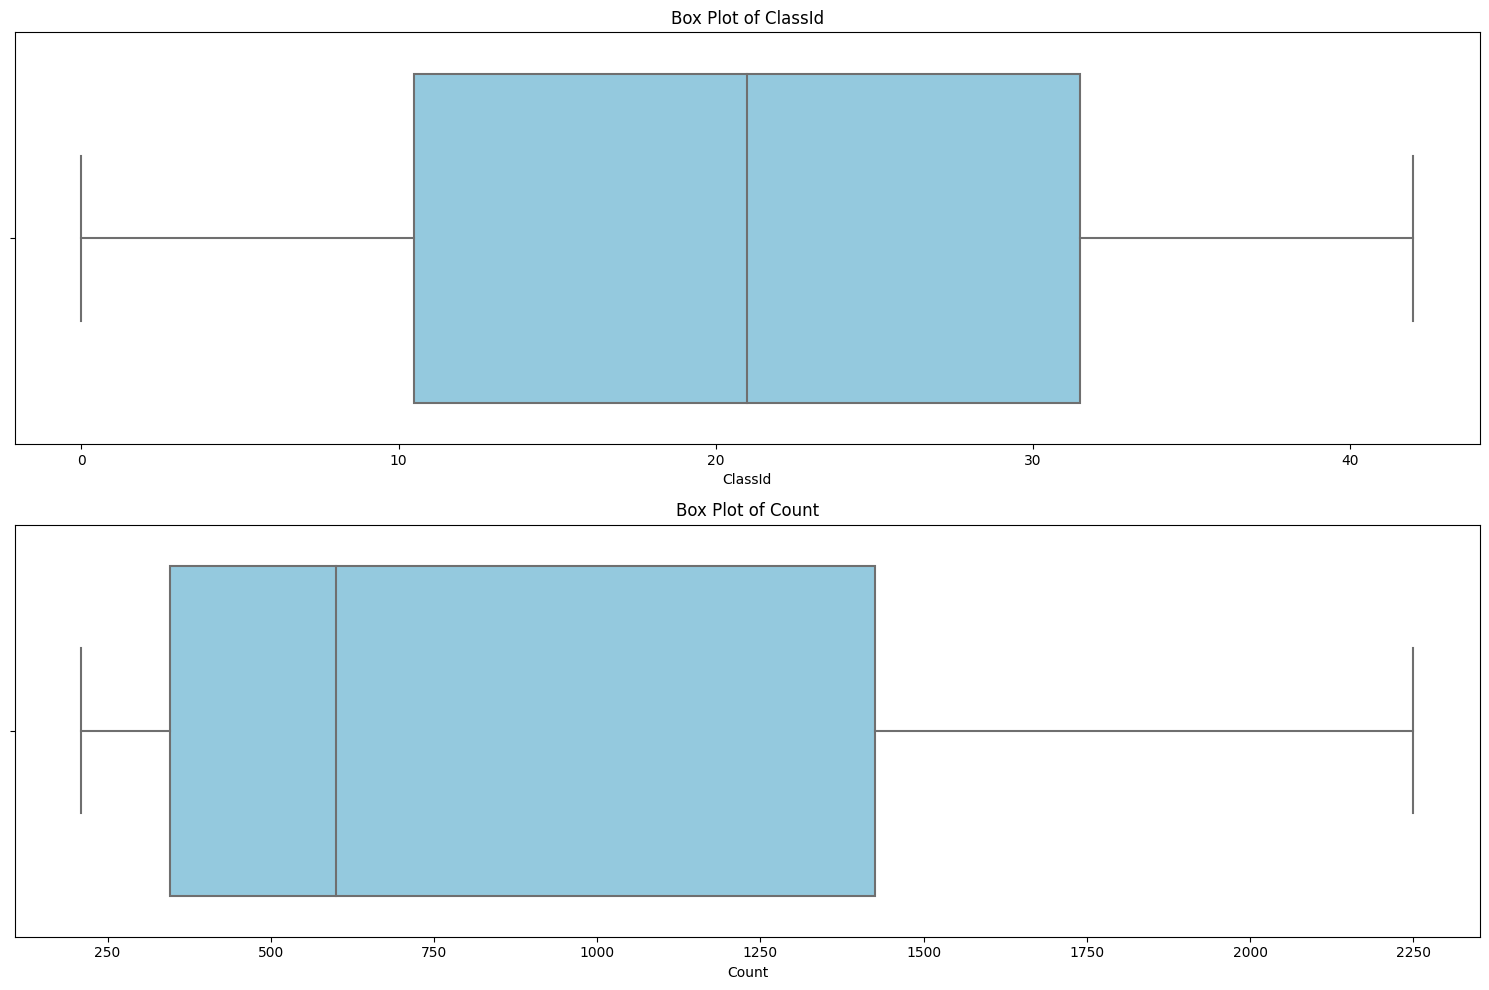

In [21]:

num_features = [col for col in df.select_dtypes(include=np.number).columns][:43]
plt.figure(figsize=(15, 5 * len(num_features)))
for i, col in enumerate(num_features):
    plt.subplot(len(num_features), 1, i + 1)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()


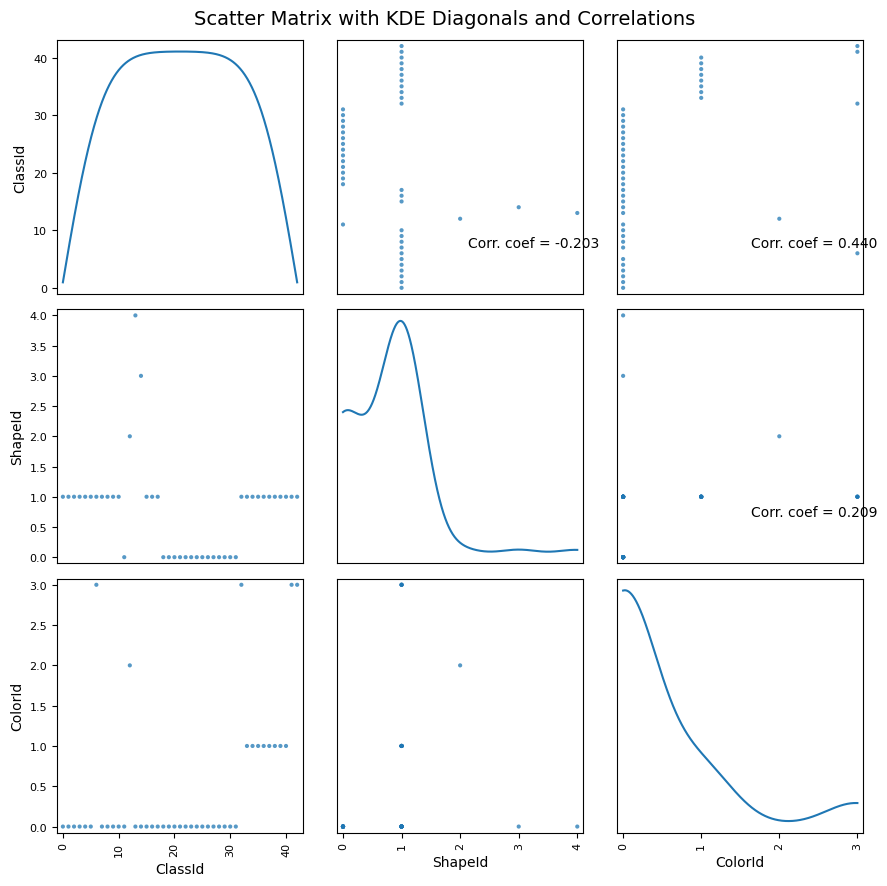

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plotScatterMatrix(df, plotSize=20, textSize=10):
    df = df.select_dtypes(include=[np.number])  # Keep only numeric columns
    df = df.dropna(axis=1)  # Drop columns with any NaNs
    df = df[[col for col in df if df[col].nunique() > 1]]  # Keep columns with >1 unique value

    columnNames = list(df)
    if len(columnNames) > 10:
        columnNames = columnNames[:10]  # Limit to first 10 columns
    df = df[columnNames]

    # Create scatter matrix
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')

    corrs = df.corr().values
    for i, j in zip(*np.triu_indices_from(corrs, k=1)):
        ax[i, j].annotate(f'Corr. coef = {corrs[i, j]:.3f}', 
                          (0.8, 0.2), 
                          xycoords='axes fraction', 
                          ha='center', va='center', 
                          fontsize=textSize)
    
    plt.suptitle('Scatter Matrix with KDE Diagonals and Correlations', fontsize=14)
    plt.tight_layout()
    plt.show()
plotScatterMatrix(df1, 9, 10)


In [27]:
data = []
labels = []
n_classes = len(os.listdir(train_path)) # 43 - not hard-coding
img_size = (32, 32)

In [28]:
for i in range(n_classes):
    print(i)
    path = os.path.join(train_path, str(i))
    images = os.listdir(path)

    print(f"Loading class {i:02d}", end = ' ')
    
    for idx, a in enumerate(images):
        try:
            img_path = os.path.join(path, a) # 추가
            img = Image.open(img_path).convert('RGB') # 수정
            img = img.resize(img_size) # 수정
            img = np.array(img)

            data.append(img)
            labels.append(i)

            # print progress - every 500 imgs
            if idx % 500 == 0:
                print('.', end = '', flush = True)
        except Execption as e: # 수정
            print(f"Error loading image: {img_path}") # 수정
            print(f"Exception: {e}") # 수정

# Convert lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

0
Loading class 00 .1
Loading class 01 .....2
Loading class 02 .....3
Loading class 03 ...4
Loading class 04 ....5
Loading class 05 ....6
Loading class 06 .7
Loading class 07 ...8
Loading class 08 ...9
Loading class 09 ...10
Loading class 10 .....11
Loading class 11 ...12
Loading class 12 .....13
Loading class 13 .....14
Loading class 14 ..15
Loading class 15 ..16
Loading class 16 .17
Loading class 17 ...18
Loading class 18 ...19
Loading class 19 .20
Loading class 20 .21
Loading class 21 .22
Loading class 22 .23
Loading class 23 ..24
Loading class 24 .25
Loading class 25 ...26
Loading class 26 ..27
Loading class 27 .28
Loading class 28 ..29
Loading class 29 .30
Loading class 30 .31
Loading class 31 ..32
Loading class 32 .33
Loading class 33 ..34
Loading class 34 .35
Loading class 35 ...36
Loading class 36 .37
Loading class 37 .38
Loading class 38 .....39
Loading class 39 .40
Loading class 40 .41
Loading class 41 .42
Loading class 42 .

In [29]:
print("Data size: ", data.shape)
print("Labels size: ", labels.shape)

# Spilt train and test dataset
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size = 0.2, random_state =42
)

# Check split data shape
print(f"Train size: [Img: {X_train.shape}, Lbls: {y_train.shape}]")
print(f"Test size: [Img: {X_test.shape}, Lbls: {y_test.shape}]")

Data size:  (39209, 32, 32, 3)
Labels size:  (39209,)
Train size: [Img: (31367, 32, 32, 3), Lbls: (31367,)]
Test size: [Img: (7842, 32, 32, 3), Lbls: (7842,)]


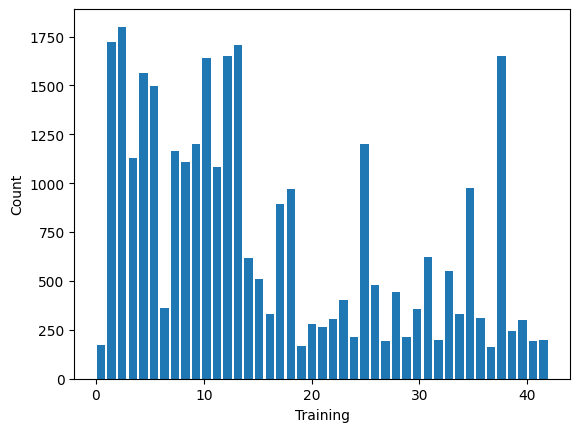

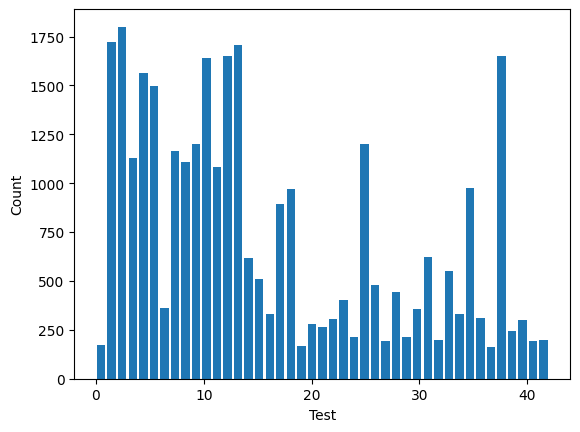

In [30]:
def draw_hist(dataset, label, num_classes):
    hist, bins = np.histogram(dataset, bins = num_classes)
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    plt.bar(center, hist, align = 'center', width = width)
    plt.xlabel(label)
    plt.ylabel("Count")
    plt.show()
draw_hist(y_train, "Training", n_classes) 
draw_hist(y_train, "Test", n_classes) 

In [ ]:
hist, bins = np.histogram(y_train, bins = n_classes)
plt.hist(y_train, bins, color = 'red', label = 'Train')
plt.hist(y_test, bins, color = 'blue', label = 'Test')
plt.legend(loc = 'upper right')
plt.show()

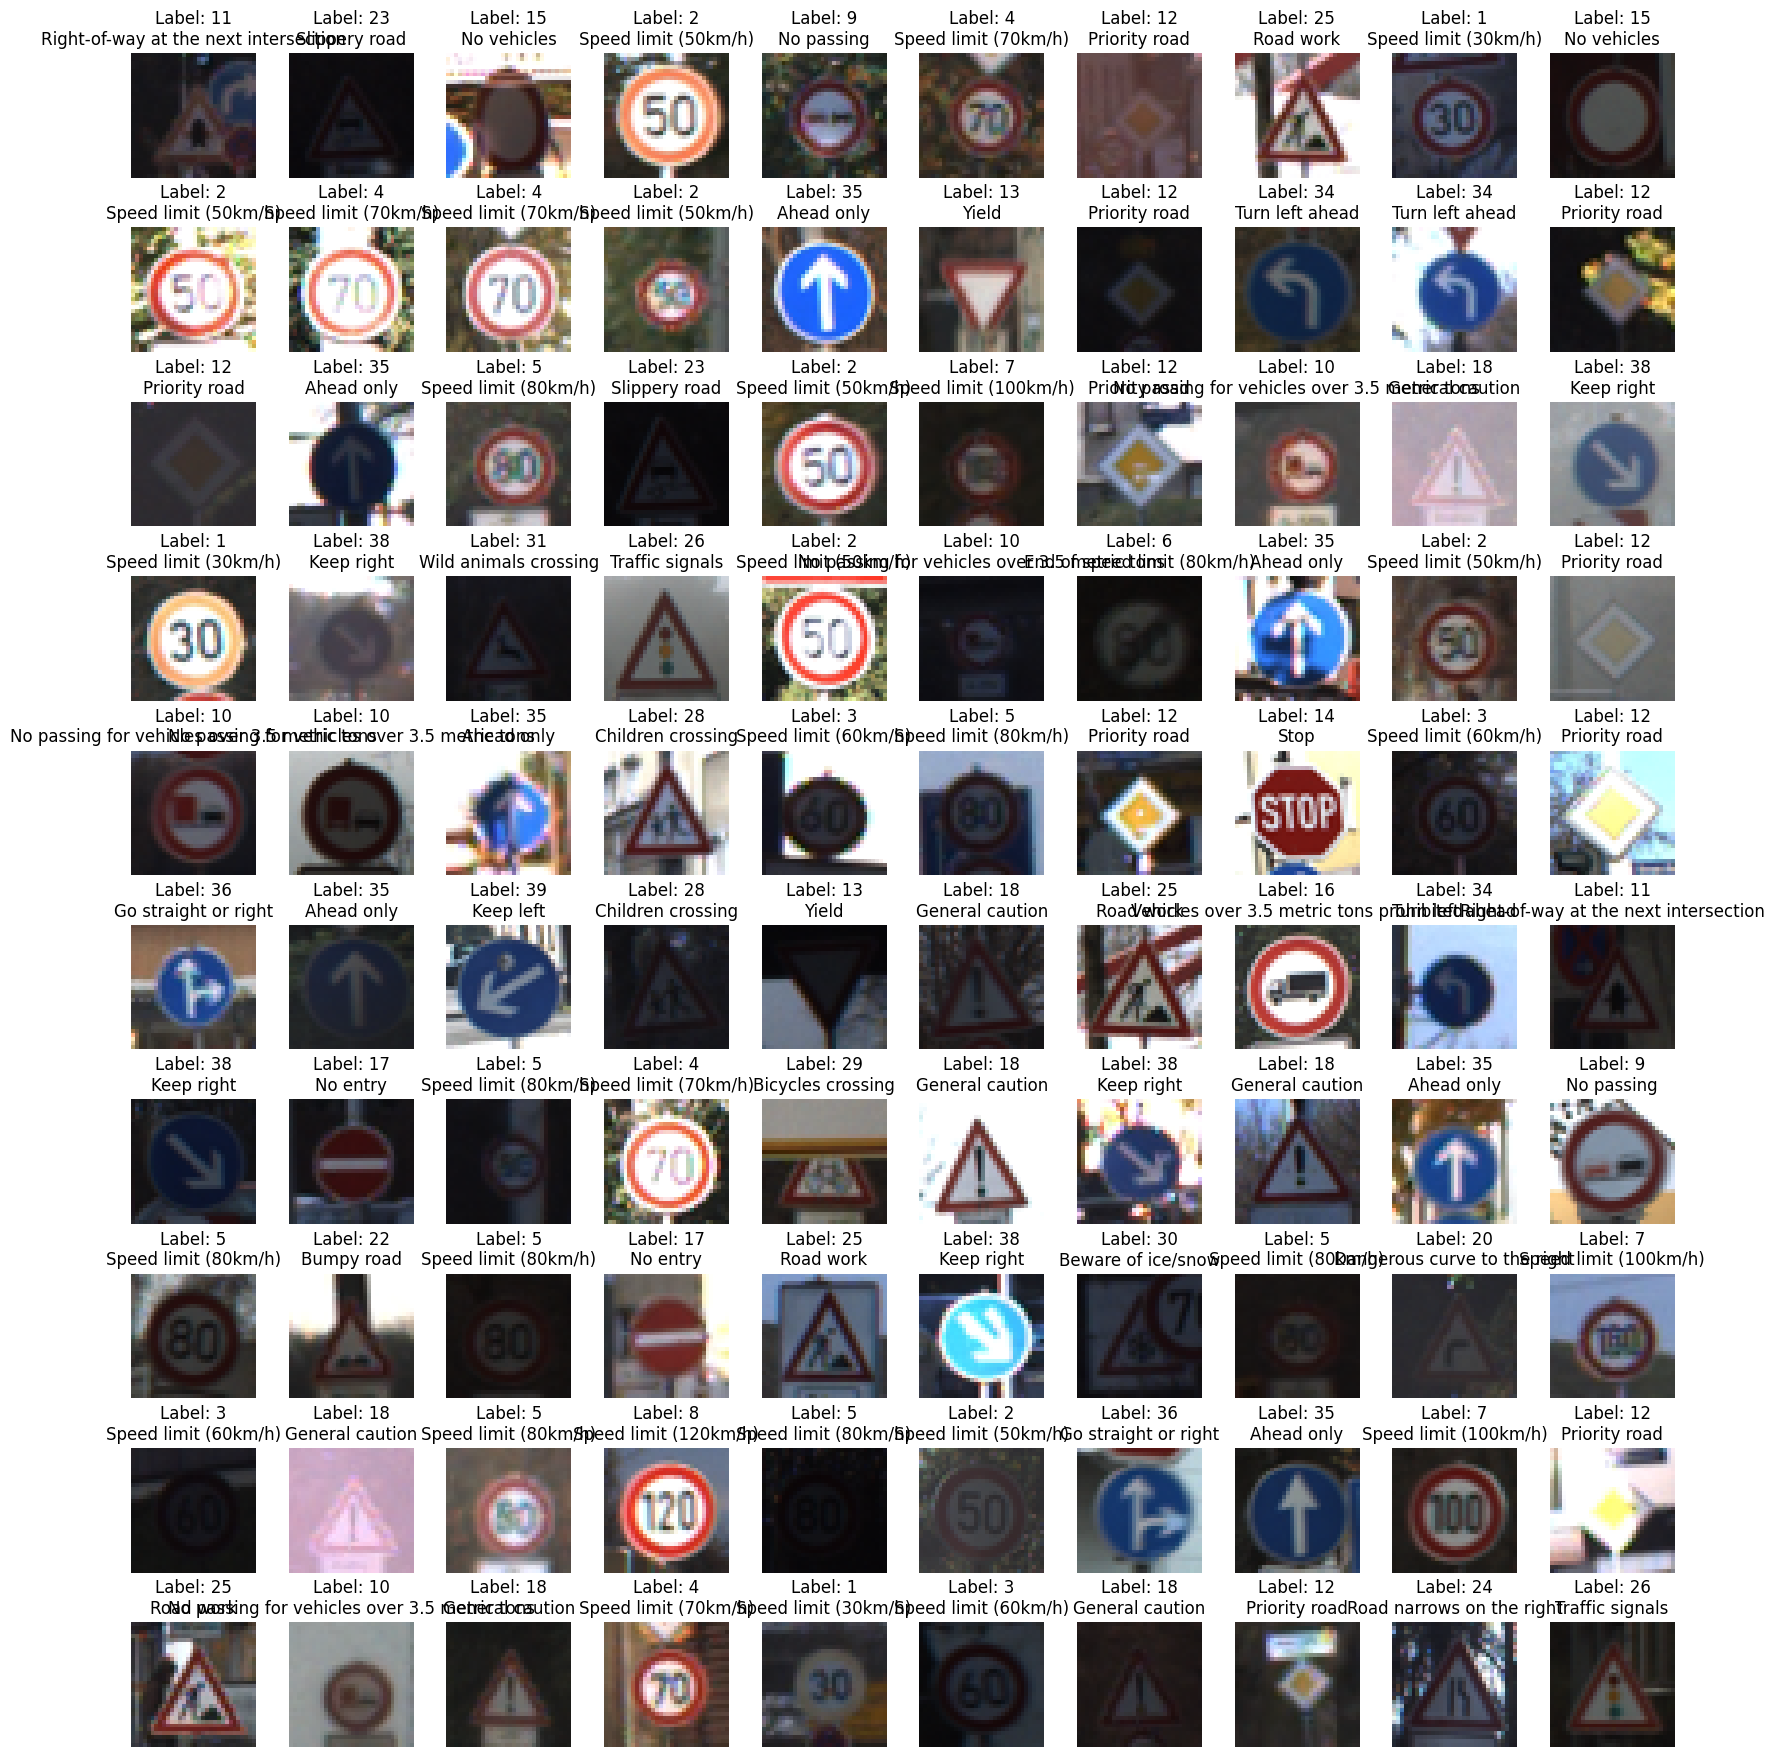

In [31]:
def display_grid(imgs, lbls, cmap = ''):
    fig, axes = plt.subplots(10, 10, figsize = (20, 22))

    for i, ax in enumerate(axes.flat):
        r = np.random.randint(imgs.shape[0])
        class_id = lbls[r]
        label_str = class_labels.get(class_id, "Unknown")

        if cmap != '':
            ax.imshow(imgs[r].astype('uint8'), cmap = cmap)
        else:
            ax.imshow(imgs[r].astype('uint8'))
        ax.grid(False)
        ax.axis('off')

        ax.set_title(f'Label: {class_id}\n{label_str}', fontsize = 12, loc = 'center')

    plt.subplots_adjust(hspace = 0.4) #Add space
    plt.show()
display_grid(X_train, y_train)